In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import itertools
%matplotlib inline

In [2]:
DATA_DIR = "./"
DATA_FILENAMES = {"bluetooth": "bt_symmetric.csv",
                  "calls": "calls.csv",
                  "sms": "sms.csv",
                  "facebook_friends": "fb_friends.csv",
                  "genders": "genders.csv"}

In [3]:
def LoadData(data_filename, data_dir):
  '''Loads data from |data_dir|/|data_filename|. Returns Pandas dataframe.'''
  return pd.read_csv(os.path.join(data_dir, data_filename))  

In [4]:
df_bt = LoadData(DATA_FILENAMES["bluetooth"], DATA_DIR)
print("bluetooth\n", df_bt.head())

df_calls = LoadData(DATA_FILENAMES["calls"], DATA_DIR)
print("\ncalls\n", df_calls.head())

df_sms = LoadData(DATA_FILENAMES["sms"], DATA_DIR)
print("\nsms\n", df_sms.head())

df_facebook_friends = LoadData(DATA_FILENAMES["facebook_friends"], DATA_DIR)
print("\nfacebook friends\n", df_facebook_friends.head())

df_genders = LoadData(DATA_FILENAMES["genders"], DATA_DIR)
print("\ngenders!\n", df_genders.head())

bluetooth
    # timestamp  user_a  user_b  rssi
0            0       0      -1     0
1            0       1      -1     0
2            0       2      -1     0
3            0       3      -2   -88
4            0       5      -1     0

calls
    timestamp  caller  callee  duration
0        184     300     301       121
1       3920     512     299       670
2       5623     301     300       504
3       9252     401     457        -1
4      15466     512       0         5

sms
    timestamp  sender  recipient
0         18     370        512
1         37     512        370
2        126     370        512
3        134       0        512
4        312     137        136

facebook friends
    # user_a  user_b
0         0     512
1         0     263
2         0     525
3         0     285
4         0     543

genders!
    # user  female
0       0       0
1       2       0
2       3       0
3       4       0
4       5       0


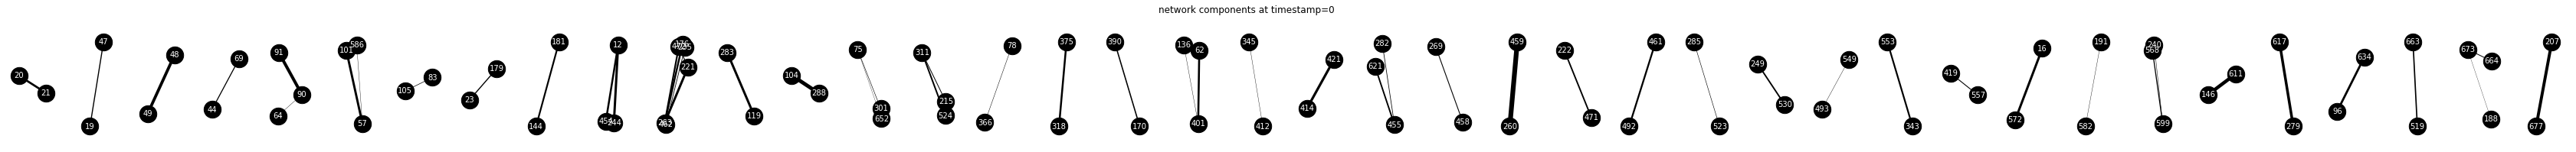

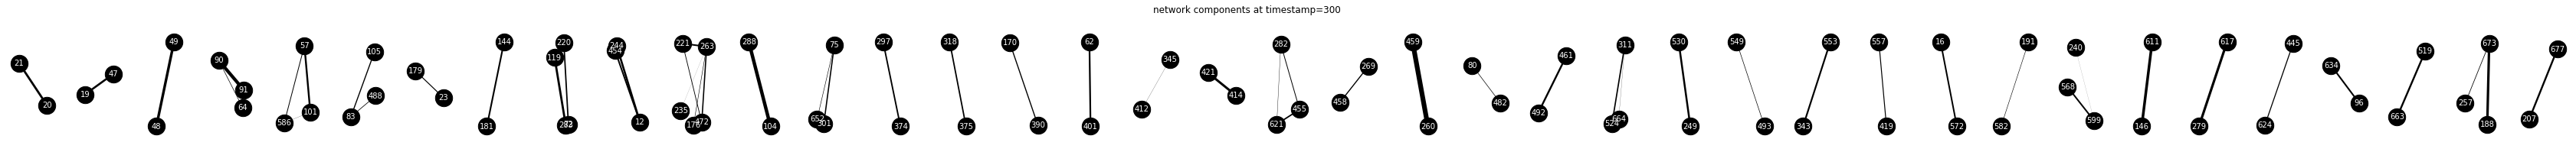

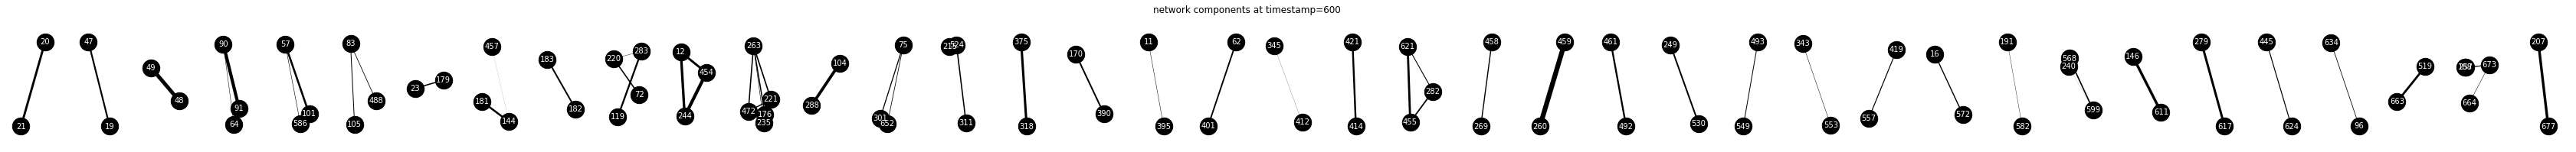

In [6]:
def connected_component_subgraphs(G):
    for c in nx.connected_components(G):
        yield G.subgraph(c)
        
def VisualizeBluetoothNetwork(df_bt, timestamp):
  """ Plots each connected component in |df_bt| network at |timestamp|."""
  # NetworkX graph to plot the results.
  G = nx.Graph()

  # In-study users (id >= 0) at given timestamp.
  in_study_users_at_timestamp = df_bt[(df_bt["# timestamp"] == timestamp)
                                      & (df_bt["user_b"] >= 0)][[
                                          "user_a", "user_b", "rssi"
                                      ]]

  # Builds an undirected network of the in-study users.
  for row in in_study_users_at_timestamp.itertuples():
    user_a = row[1]
    user_b = row[2]
    rssi = row[3]
    G.add_edge(user_a, user_b, weight=rssi)

  # For clarity, we consier each connected component separately.  
  connected_components = list(connected_component_subgraphs(G))
  fig, axs = plt.subplots(1, len(connected_components), figsize=(60, 3))
  
  # Plots the connected components of the network.
  fig.suptitle("network components at timestamp={}".format(timestamp))
  [
      nx.draw(
          connected_component,
          # Positions of nodes are calculatued using spring layout.
          pos=nx.spring_layout(connected_component, scale=0.2),
          ax=axs[i],
          # Width of the edges is based on higher RSSI = stronger edge.
          width=[(100 + connected_component[u][v]["weight"]) / 10.0
                 for u, v in connected_component.edges()],
          node_size=500,
          node_color="black",
          with_labels=True,
          font_size=10,
          font_color="white")
      for i, connected_component in enumerate(connected_components)
  ]


VisualizeBluetoothNetwork(df_bt, 0)
VisualizeBluetoothNetwork(df_bt, 300)
VisualizeBluetoothNetwork(df_bt, 600)

In [ ]:
def  GetBluetoothNetwork(df_bt, timestamp):
  G = nx.Graph()

  # In-study users (id >= 0) at given timestamp.
  in_study_users_at_timestamp = df_bt[(df_bt["# timestamp"] == timestamp)
                                      & (df_bt["user_b"] >= 0)][[
                                          "user_a", "user_b", "rssi"
                                      ]]

  # Builds an undirected network of the in-study users.
  for row in in_study_users_at_timestamp.itertuples():
    user_a = row[1]
    user_b = row[2]
    rssi = row[3]
    G.add_edge(user_a, user_b, weight=rssi)
    
G = GetBluetoothNetwork(df_bt, 0)


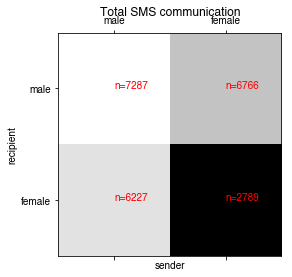

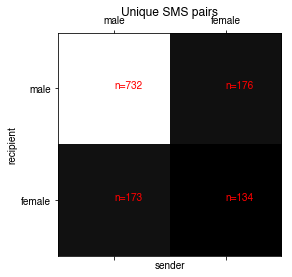

In [6]:
def VisualizeTextMessages(df_sms, df_genders):
  """Plots the SMS communication by gender of senders and recipients."""

  # Creates SMS network including gender of the senders.
  df_sms_with_gender_sender = pd.merge(
      df_sms, df_genders, left_on="sender", right_on="# user").rename(
          index=str, columns={
              "female": "female_sender"
          }).drop(
              "# user", axis=1)

  # Creates SMS network including gender of the recipients.
  df_sms_with_gender = pd.merge(
      df_sms_with_gender_sender,
      df_genders,
      left_on="recipient",
      right_on="# user").rename(
          index=str, columns={
              "female": "female_recipient"
          }).drop(
              "# user", axis=1)

  # Computes total communication (all messages) and number of unique pairs based
  # on sender and recipient gender.
  totals = np.zeros((2, 2))
  unique_pairs = np.zeros((2, 2))
  for female_sender in [0, 1]:
    for female_recipient in [0, 1]:
      totals[female_sender, female_recipient] = df_sms_with_gender[
          (df_sms_with_gender["female_sender"] == female_sender)
          &
          (df_sms_with_gender["female_recipient"] == female_recipient)].shape[0]
      unique_pairs[female_sender, female_recipient] = df_sms_with_gender[
          (df_sms_with_gender["female_sender"] == female_sender)
          & (df_sms_with_gender["female_recipient"] == female_recipient)][[
              "sender", "recipient"
          ]].drop_duplicates().shape[0]

  # Plots the breakdowns.
  plt.matshow(totals, cmap=plt.cm.gray)
  plt.grid(False)
  plt.xlabel("sender")
  plt.ylabel("recipient")
  plt.xticks([0, 1], ["male", "female"])
  plt.yticks([0, 1], ["male", "female"])
  [
      plt.text(
          sender,
          recipient,
          "n={}".format(int(totals[sender][recipient])),
          color="red")
      for sender, recipient in itertools.product([0, 1], [0, 1])
  ]
  plt.title("Total SMS communication")

  plt.matshow(unique_pairs, cmap=plt.cm.gray)
  plt.grid(False)
  plt.xlabel("sender")
  plt.ylabel("recipient")
  plt.xticks([0, 1], ["male", "female"])
  plt.yticks([0, 1], ["male", "female"])
  [
      plt.text(
          sender,
          recipient,
          "n={}".format(int(unique_pairs[sender][recipient])),
          color="red")
      for sender, recipient in itertools.product([0, 1], [0, 1])
  ]
  plt.title("Unique SMS pairs")


VisualizeTextMessages(df_sms, df_genders)